In [1]:
%load_ext Cython
%load_ext line_profiler
import numpy
import itertools
import seaborn
import pandas
import statsmodels
import statsmodels.api

In [2]:
%%cython
# cython: linetrace=True
# cython: binding=True
# distutils: define_macros=CYTHON_TRACE_NOGIL=1
import numpy
import cython
import random
from cython.parallel import prange
cimport numpy as cnumpy
cimport cython

@cython.nonecheck(False)
@cython.boundscheck(False)
def get_permutations(long[:,:] cb_ids, long[:] sites, long[:] sub_branches, double[:] p, long niter):
    cdef cnumpy.ndarray[cnumpy.uint8_t, ndim = 3, cast=True] ps
    cdef cnumpy.ndarray[cnumpy.uint8_t, ndim = 2, cast=True] sub_bool_array
    cdef long[:,:] num_shared_sub = numpy.zeros(shape=(cb_ids.shape[0], niter), dtype=numpy.long)
    cdef long[:] num_shared_sub2 = numpy.zeros(shape=(niter), dtype=numpy.long)
    cdef long size
    cdef long prev
    cdef long[:] site_indices
    cdef Py_ssize_t i,j,s,b # Py_ssize_t is the proper C type for Python array indices.
    ps = numpy.zeros(shape=(sub_branches.shape[0], niter, sites.shape[0]), dtype=numpy.bool_)
    for i in range(sub_branches.shape[0]):
        size = sub_branches[i]
        if size!=0:
            if size in sub_branches[:i]:
                prev = numpy.arange(i)[numpy.equal(sub_branches[:i], size)][0]
                ps[i,:,:] = ps[prev,numpy.random.permutation(numpy.arange(ps.shape[1])),:]
            else:
                for j in range(niter):
                    site_indices = numpy.random.choice(a=sites, size=size, replace=False, p=p)
                    ps[i,j,site_indices] = True
    for i in range(cb_ids.shape[0]):
        for b in range(cb_ids[i,:].shape[0]):
            if cb_ids[i,b]==cb_ids[i,0]:
                sub_bool_array = ps[cb_ids[i,b],:,:].copy()
            else:
                sub_bool_array *= ps[cb_ids[i,b],:,:]
        num_shared_sub2 = sub_bool_array.sum(axis=1)
        num_shared_sub[i,:] = num_shared_sub2
    return numpy.asarray(num_shared_sub)


In [15]:
sites = numpy.arange(100)
sub_branches = numpy.random.choice([0,5,10,20], 100)
p = numpy.arange(sites.shape[0])+10
p = p/p.sum()
niter = 100
cb_ids = numpy.array(list(itertools.combinations(numpy.arange(sub_branches.shape[0]), 2)), dtype=numpy.int64)

hoge = get_permutations(cb_ids, sites, sub_branches, p, niter)

In [27]:
sites = numpy.arange(100)
sub_branches = numpy.random.choice([0,5,10,20], 100)
p = numpy.arange(sites.shape[0])+10
p = p/p.sum()
niter = 100
cb_ids = numpy.array(list(itertools.combinations(numpy.arange(sub_branches.shape[0]), 2)), dtype=numpy.int64)

%timeit hoge = get_permutations(cb_ids, sites, sub_branches, p, niter)
#%timeit hoge = get_permutations2(cb_ids, sites, sub_branches, p, niter)
%timeit hoge = get_permutations(cb_ids, sites, sub_branches, p, niter)
#%timeit hoge = get_permutations2(cb_ids, sites, sub_branches, p, niter)
%timeit hoge = get_permutations(cb_ids, sites, sub_branches, p, niter)
#%timeit hoge = get_permutations2(cb_ids, sites, sub_branches, p, niter)

381 ms ± 85.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
172 ms ± 13.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
309 ms ± 16.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
173 ms ± 16 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
298 ms ± 1.18 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
158 ms ± 717 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [49]:
L = numpy.arange(4) # stone labels (0,1,2,3)
MN = numpy.array([2,3]) # M and N
cb_ids = numpy.expand_dims(numpy.arange(MN.shape[0]), axis=0)
p = numpy.array([0.1,0.2,0.3,0.4,]) # stone frequencies
#p = numpy.array([0.25,0.25,0.25,0.25]) # stone frequencies
niter = 10000 # Number of permutations

# Kamesan method
X = sum([ numpy.array(probs).prod() for probs in list(itertools.combinations(p, MN[0])) ])
Y = sum([ numpy.array(probs).prod() for probs in list(itertools.combinations(p, MN[1])) ])
Z = X * Y
P_k1 = (1/Z)*(3*p.prod())*(p.sum())
print('Kamesan: Probability of k={} is {}'.format(1,P_k1))

# Simulation
out = get_permutations(cb_ids, L, MN, p, niter)
for i in [0,1,2,3,4]:
    prob = (out==i).sum()/niter
    print('Permutation: Probability of k={} is {}'.format(i,prob))

Kamesan: Probability of k=1 is 0.4114285714285715
Permutation: Probability of k=0 is 0.0
Permutation: Probability of k=1 is 0.36762
Permutation: Probability of k=2 is 0.63238
Permutation: Probability of k=3 is 0.0
Permutation: Probability of k=4 is 0.0


In [28]:
def get_permutations2_days_sentinel():
    pass

%lprun -f get_permutations2 get_permutations2(cb_ids, sites, sub_branches, p, niter)

Timer unit: 1e-06 s

Total time: 0.290278 s
File: /Users/kf/.ipython/cython/_cython_magic_6fbd1904e2109f3e00b755ab151924b2.pyx
Function: get_permutations2 at line 40

Line #      Hits         Time  Per Hit   % Time  Line Contents
    40                                           def get_permutations2(long[:,:] cb_ids, long[:] sites, long[:] sub_branches, double[:] p, long niter):
    41                                               cdef cnumpy.ndarray[cnumpy.uint8_t, ndim = 3, cast=True] ps
    42                                               cdef cnumpy.ndarray[cnumpy.uint8_t, ndim = 2, cast=True] sub_bool_array
    43         1        381.0    381.0      0.1      cdef long[:,:] num_shared_sub = numpy.zeros(shape=(cb_ids.shape[0], niter), dtype=numpy.long)
    44         1         17.0     17.0      0.0      cdef long[:] num_shared_sub2 = numpy.zeros(shape=(niter), dtype=numpy.long)
    45                                               cdef long size
    46                              

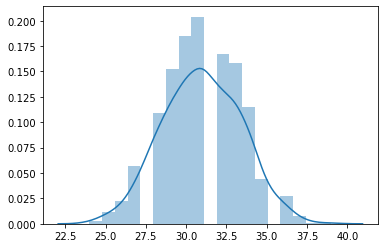

In [29]:
dfq = get_permutations(cb_ids, sites, sub_branches+50, p, niter=1000)
seaborn.distplot(dfq[0,:])

In [30]:
import scipy
fit_alpha, fit_loc, fit_beta = scipy.stats.gamma.fit(dfq[0,:])
print(fit_alpha, fit_loc, fit_beta)

311376402.79534876 -42761.464505731135 0.0001374299315335842


In [37]:
a = numpy.random.choice([0,10,20,30], 1000)
v = 30
(a>=v).sum() / len(a)

0.243

In [56]:
x = 'x'
y = 'y'
df = pandas.DataFrame({y:dfq[0,:], x:numpy.ones_like(dfq[0,:])})
glm_formula = y+" ~ "+x
reg_family = family=statsmodels.api.families.Binomial(link=statsmodels.api.families.links.log)
mod = statsmodels.formula.api.glm(formula=glm_formula, data=df, family=reg_family)
res = mod.fit()
res

/Users/kf/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  """
/Users/kf/miniconda3/lib/python3.7/site-packages/statsmodels/genmod/generalized_linear_model.py:278: DomainWarning: The log link function does not respect the domain of the Binomial family.
  DomainWarning)


In [57]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                 1000
Model:                            GLM   Df Residuals:                      999
Model Family:                Binomial   Df Model:                            0
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Mon, 09 Mar 2020   Deviance:                      -6.7696
Time:                        03:54:31   Pearson chi2:                 2.80e+19
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.414e+11   2162.231   6.54e+07      0.000    1.41e+11    1.41e+11
x          -1.414e+11   2162.231  -6.54e+07      0.000   -1.41e+11   -1.41e+11
==============================================================================
"""

In [52]:
res.summary()

/Users/kf/miniconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/Users/kf/miniconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/kf/miniconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/kf/miniconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                 1000
Model:                            GLM   Df Residuals:                      999
Model Family:                 Poisson   Df Model:                            0
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2731.9
Date:                Mon, 09 Mar 2020   Deviance:                       190.42
Time:                        03:53:35   Pearson chi2:                     190.
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.4331      0.006    604.215      0.000       3.422       3.444
x                   0          0        nan        nan           0           0
==============================================================================
"""